In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt # 학습과정 시각화
# scale조정, train_test_split 등을 추가


In [4]:
# mnist 데이터 일부를 이미지 출력하기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [5]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

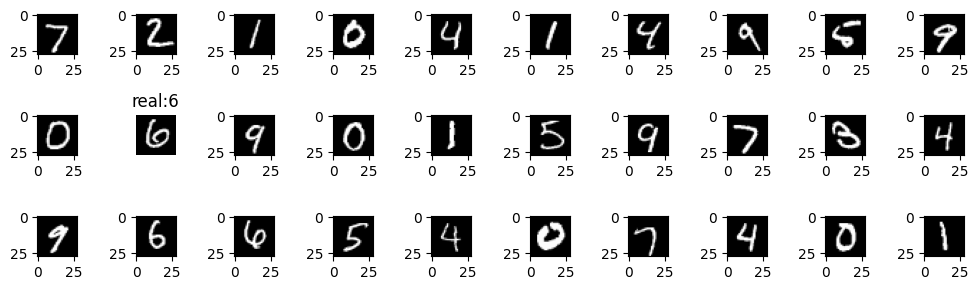

In [6]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col, plt_row))
plt.rcParams['figure.figsize'] = (plt_col, plt_row)


fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
axarr[1,1].imshow(X_test[11], cmap='gray')
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axarr[1,1].axis('off')
axarr[1,1].set_title(f'real:{y_test[11]}')

for i in range(plt_row*plt_col):
    ax = axarr[i//10, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
plt.tight_layout()

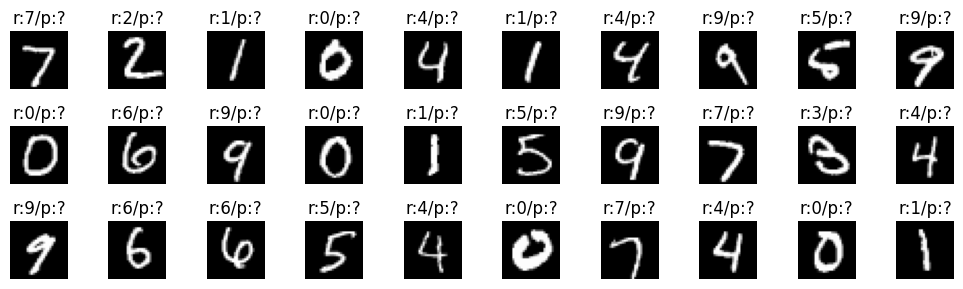

In [7]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col, plt_row))
plt.rcParams['figure.figsize'] = (plt_col, plt_row)


fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
axarr[1,1].imshow(X_test[11], cmap='gray')
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axarr[1,1].axis('off')
axarr[1,1].set_title(f'real:{y_test[11]}')

for i in range(plt_row*plt_col):
    ax = axarr[i//10, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

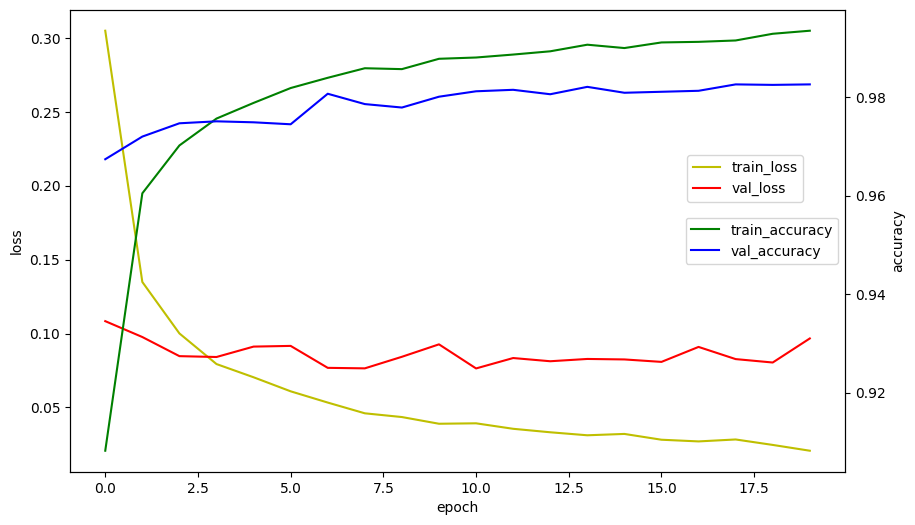

CPU times: total: 7min 8s
Wall time: 1min 24s


In [8]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])
# to_categorical(y_train)[0]
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
# Train 5만->700개, Val만->300개 (목적:수업시간 중 fit시간 절약)
# train_idx = np.random.choice(50000, 700) # 0~50000미만의 수 700개 비복원추출
# val_idx   = np.random.choice(10000, 300)
# train_X = train_X[train_idx]
# train_Y = train_Y[train_idx]
# val_X   = val_X[val_idx]
# val_Y   = val_Y[val_idx]
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=20,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)
# 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()


In [9]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.984499990940094

In [10]:
#틀린 갯수
len(test_Y) - len(test_Y) * acc

155.00009059906006

In [11]:
# 틀린 이미지만 출력하기 위해, 예츩값과 실제값
real = test_Y.argmax(axis=1)
real = np.argmax(test_Y, axis=1)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [34]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [38]:
# 예측값
y_hat = model.predict(test_X, verbose=0).argmax(axis=1)


In [20]:
y_test.shape, y_hat.shape # 실제값과 예측값

NameError: name 'y_hat' is not defined

In [42]:
# 성능 평가표 (교차표, 혼동행렬)
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,1,0,1,0,1,2,0,0,1
1,0,1126,2,0,0,1,1,0,5,0
2,4,0,1016,2,0,0,2,5,3,0
3,0,0,1,1001,0,0,0,3,2,3
4,0,1,5,0,963,0,3,1,0,9
5,2,0,0,19,2,862,4,0,1,2
6,5,2,0,1,4,5,937,0,4,0
7,1,0,6,0,1,0,0,1009,2,9
8,2,0,6,11,4,4,0,3,941,3


In [19]:

plt_row = 2
plt_col = 10
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

NameError: name 'y_hat' is not defined

NameError: name 'y_hat' is not defined

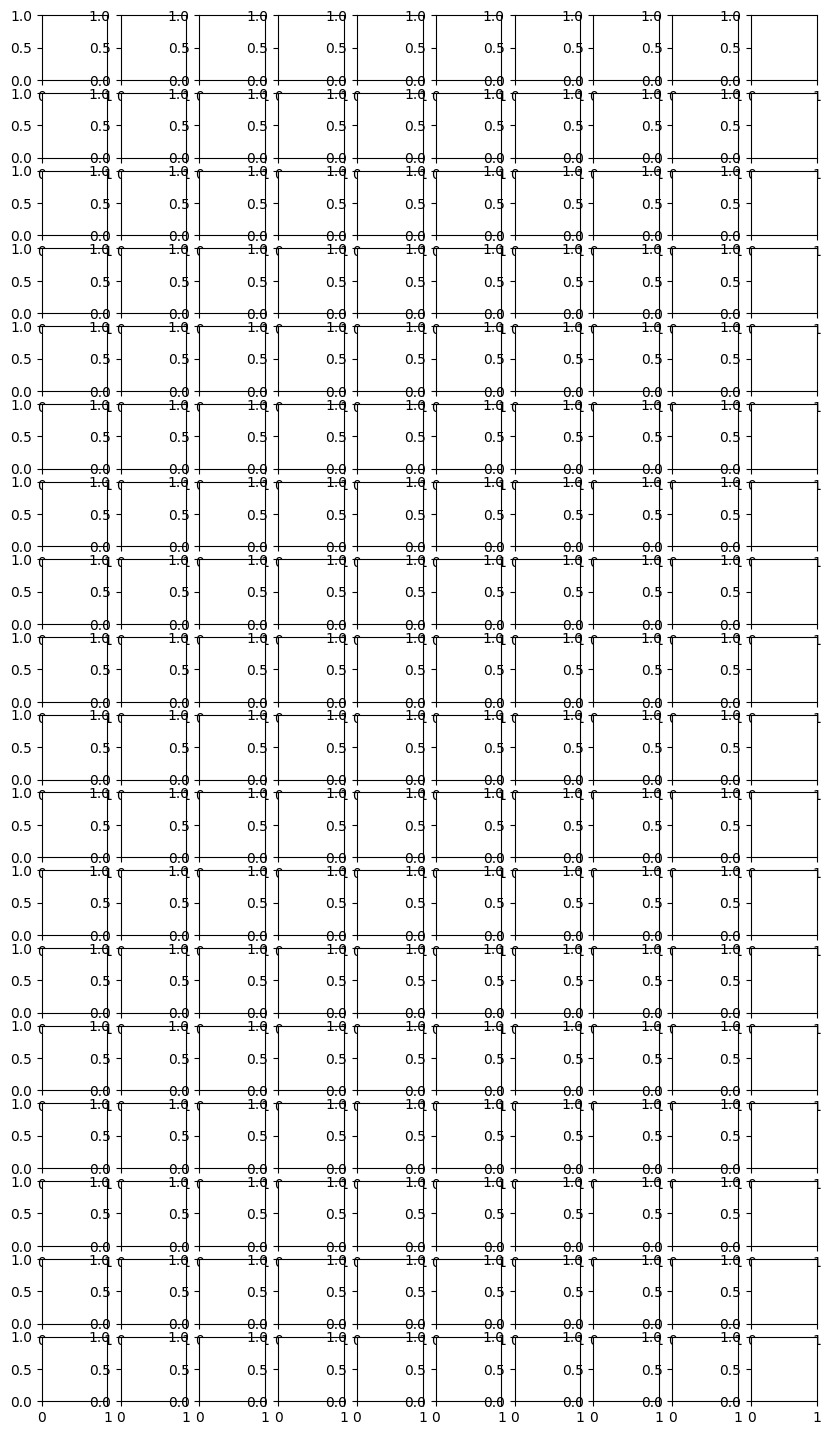

In [17]:
plt_row = 18
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
plt.tight_layout()
